In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/fertilizer-prediction/Fertilizer Prediction.csv


## **Importing the Required Library**

In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, log_loss
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
import catboost as cat_
import seaborn as sns
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
import optuna.integration.lightgbm as lgb2
import pickle


## **Reading Dataset**

In [3]:
data = pd.read_csv("/kaggle/input/fertilizer-prediction/Fertilizer Prediction.csv")

In [4]:
def null_check(data):
    return data.isnull().sum(axis = 0).reset_index();

In [5]:
def duplicate_check(data):
    duplicates = data.duplicated().sum(axis=0)
    print(f'Duplicated exist {duplicates == True}')
    return 

In [6]:
def data_information(data):
    print('Data Information Table')
    display(data.info(verbose = True,show_counts=True))
    print('\n Data Head Table')
    display(data.head())
    print('\n Data Describe Information Table')
    display(data.describe())
    print(f'\n Data Shape: {data.shape}')
    print(f'\n Data Columns {data.columns}')
    print('\n Data Null item Information Table')
    display(null_check(data))
    duplicate_check(data)
    return

In [7]:
data_information(data)

Data Information Table
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Temparature      99 non-null     int64 
 1   Humidity         99 non-null     int64 
 2   Moisture         99 non-null     int64 
 3   Soil Type        99 non-null     object
 4   Crop Type        99 non-null     object
 5   Nitrogen         99 non-null     int64 
 6   Potassium        99 non-null     int64 
 7   Phosphorous      99 non-null     int64 
 8   Fertilizer Name  99 non-null     object
dtypes: int64(6), object(3)
memory usage: 7.1+ KB


None


 Data Head Table


Temparature  Humidity   Moisture Soil Type  Crop Type  Nitrogen  Potassium  \
0           26         52        38     Sandy      Maize        37          0   
1           29         52        45     Loamy  Sugarcane        12          0   
2           34         65        62     Black     Cotton         7          9   
3           32         62        34       Red    Tobacco        22          0   
4           28         54        46    Clayey      Paddy        35          0   

   Phosphorous Fertilizer Name  
0            0            Urea  
1           36             DAP  
2           30        14-35-14  
3           20           28-28  
4            0            Urea


 Data Describe Information Table


Temparature  Humidity    Moisture   Nitrogen  Potassium  Phosphorous
count    99.000000  99.000000  99.000000  99.000000  99.000000    99.000000
mean     30.282828  59.151515  43.181818  18.909091   3.383838    18.606061
std       3.502304   5.840331  11.271568  11.599693   5.814667    13.476978
min      25.000000  50.000000  25.000000   4.000000   0.000000     0.000000
25%      28.000000  54.000000  34.000000  10.000000   0.000000     9.000000
50%      30.000000  60.000000  41.000000  13.000000   0.000000    19.000000
75%      33.000000  64.000000  50.500000  24.000000   7.500000    30.000000
max      38.000000  72.000000  65.000000  42.000000  19.000000    42.000000


 Data Shape: (99, 9)

 Data Columns Index(['Temparature', 'Humidity ', 'Moisture', 'Soil Type', 'Crop Type',
       'Nitrogen', 'Potassium', 'Phosphorous', 'Fertilizer Name'],
      dtype='object')

 Data Null item Information Table


index  0
0      Temparature  0
1        Humidity   0
2         Moisture  0
3        Soil Type  0
4        Crop Type  0
5         Nitrogen  0
6        Potassium  0
7      Phosphorous  0
8  Fertilizer Name  0

Duplicated exist False


In [8]:
for column in data.columns : 
    print('Number of unique data for {0} is {1}'.format(column , len(data[column].unique())))
    print('unique data for {0} is {1}'.format(column , data[column].unique()))
    print('=====================================')

Number of unique data for Temparature is 14
unique data for Temparature is [26 29 34 32 28 25 33 30 27 31 35 37 36 38]
Number of unique data for Humidity  is 13
unique data for Humidity  is [52 65 62 54 50 64 60 58 68 70 67 53 72]
Number of unique data for Moisture is 41
unique data for Moisture is [38 45 62 34 46 35 64 50 42 33 28 48 65 41 31 49 39 52 44 53 37 63 30 32
 36 40 27 61 26 58 60 43 29 51 47 54 56 57 55 59 25]
Number of unique data for Soil Type is 5
unique data for Soil Type is ['Sandy' 'Loamy' 'Black' 'Red' 'Clayey']
Number of unique data for Crop Type is 11
unique data for Crop Type is ['Maize' 'Sugarcane' 'Cotton' 'Tobacco' 'Paddy' 'Barley' 'Wheat' 'Millets'
 'Oil seeds' 'Pulses' 'Ground Nuts']
Number of unique data for Nitrogen is 24
unique data for Nitrogen is [37 12  7 22 35  9 41 21 13 14 36 24 10 38 39 11 23  8 15  5 40  6 42  4]
Number of unique data for Potassium is 13
unique data for Potassium is [ 0  9 10  7 15 13 14  8 12 18 19 16 17]
Number of unique data for

## **Visualization**

In [9]:
def make_pie(feature) :
    sns.set(rc = {'figure.figsize':(30, 20)})
    plt.pie(data[feature].value_counts(),labels=list(data[feature].value_counts().index),
        autopct ='%1.2f%%' , labeldistance = 1.1,explode = [0.05 for i in range(len(data[feature].value_counts()))] )
    plt.show()

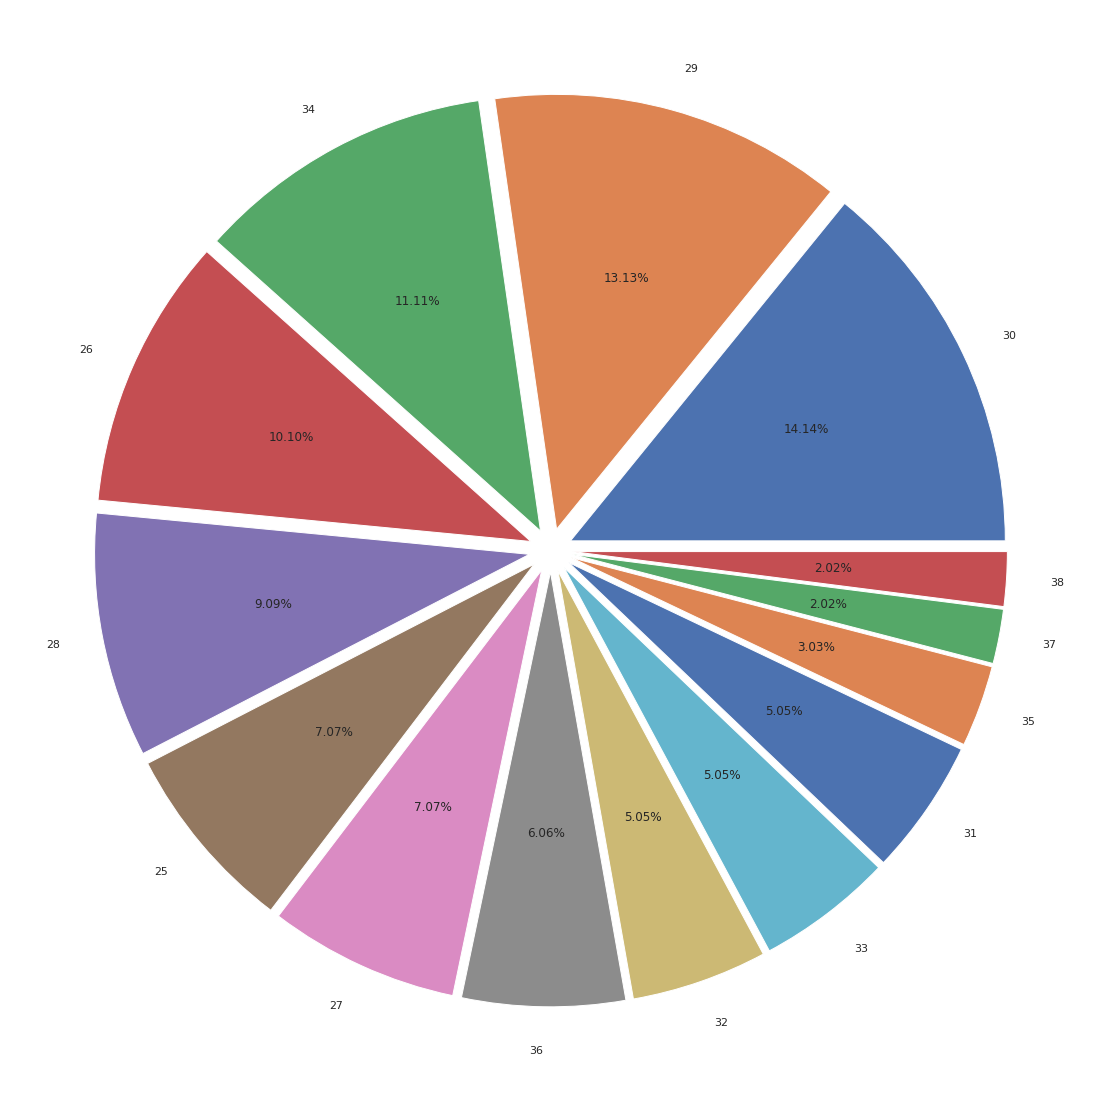

In [10]:
make_pie('Temparature')

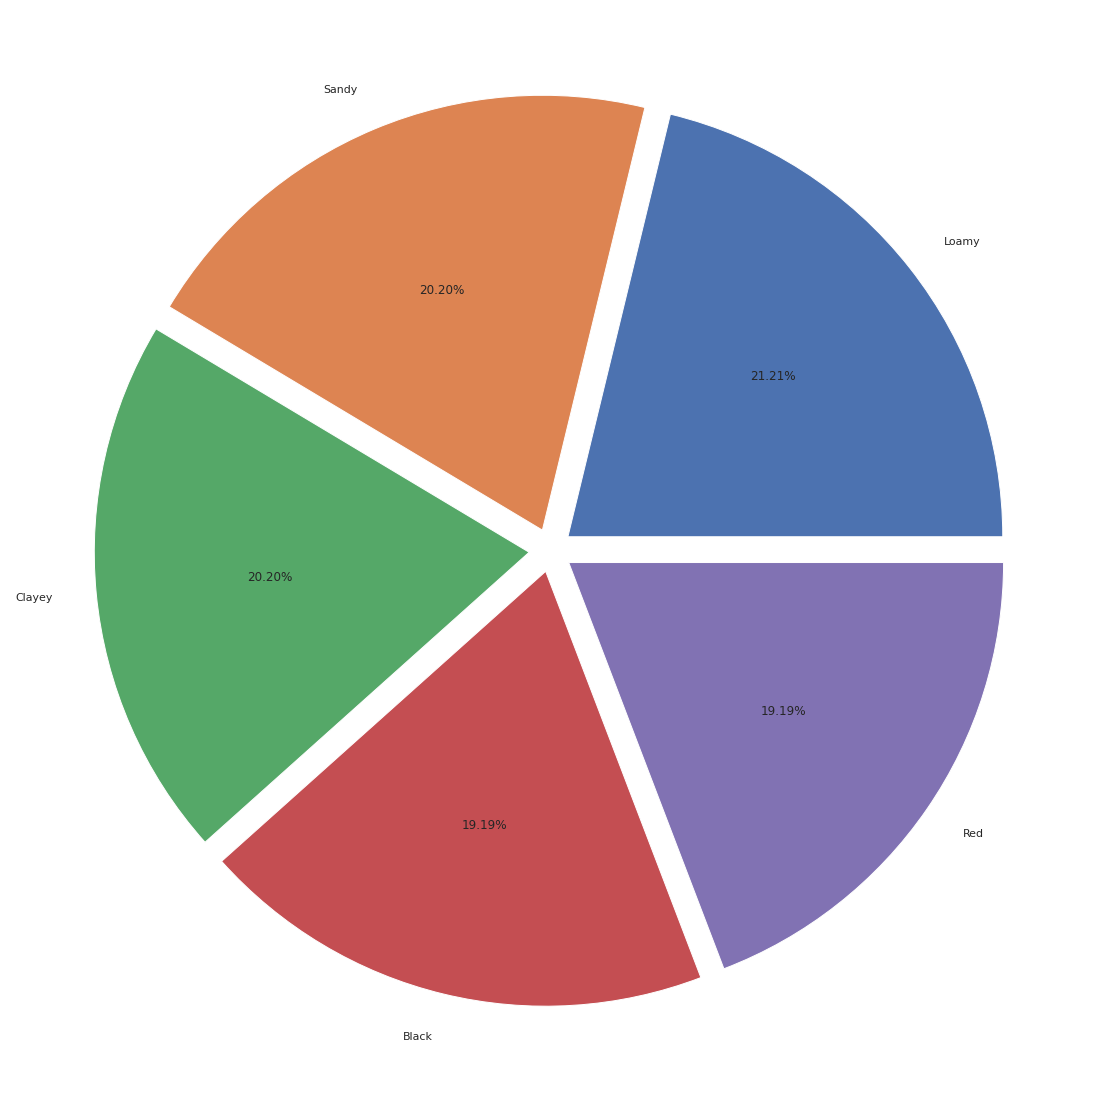

In [11]:
make_pie('Soil Type')

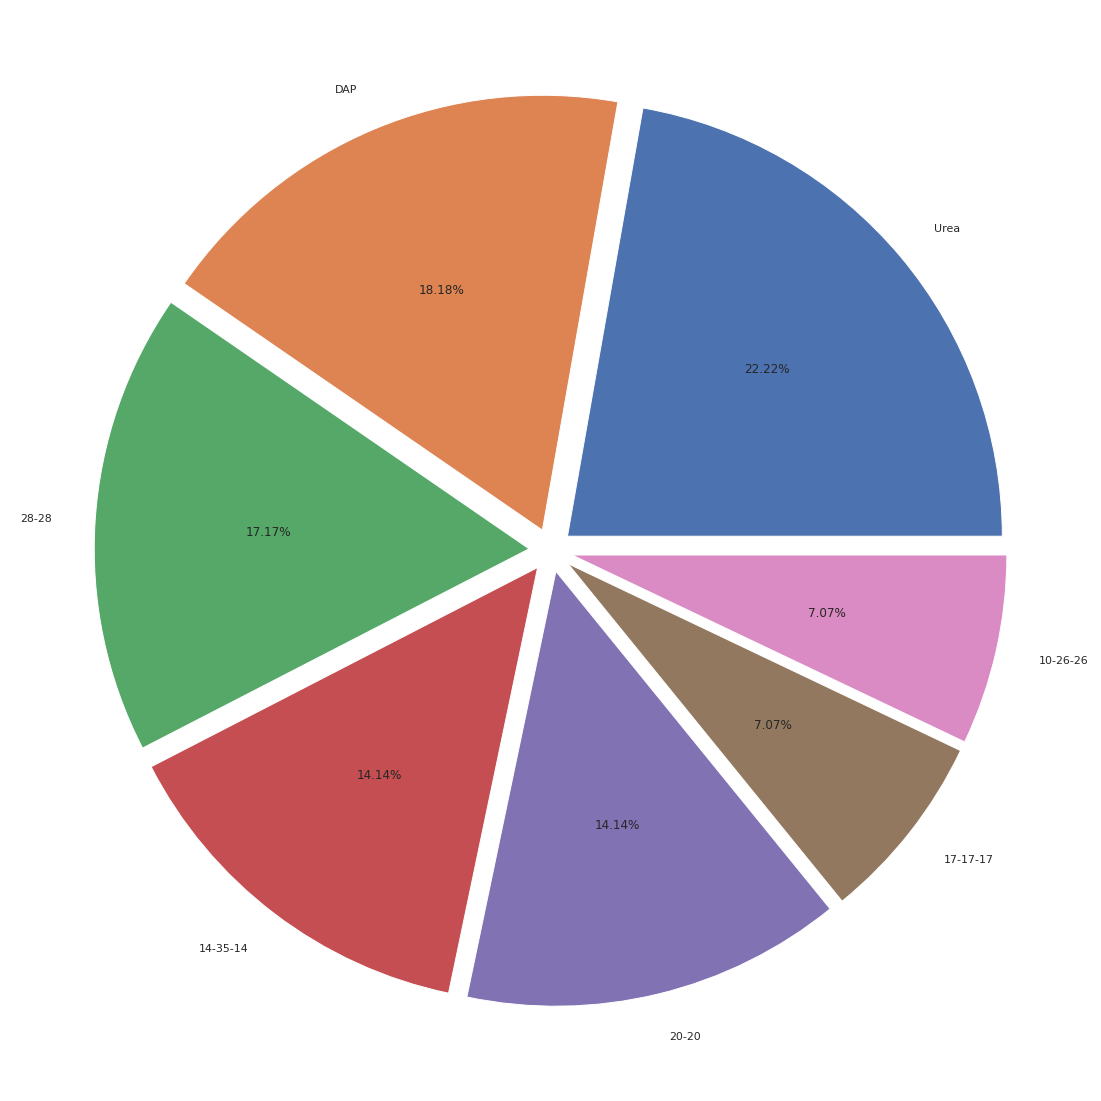

In [12]:
make_pie('Fertilizer Name')

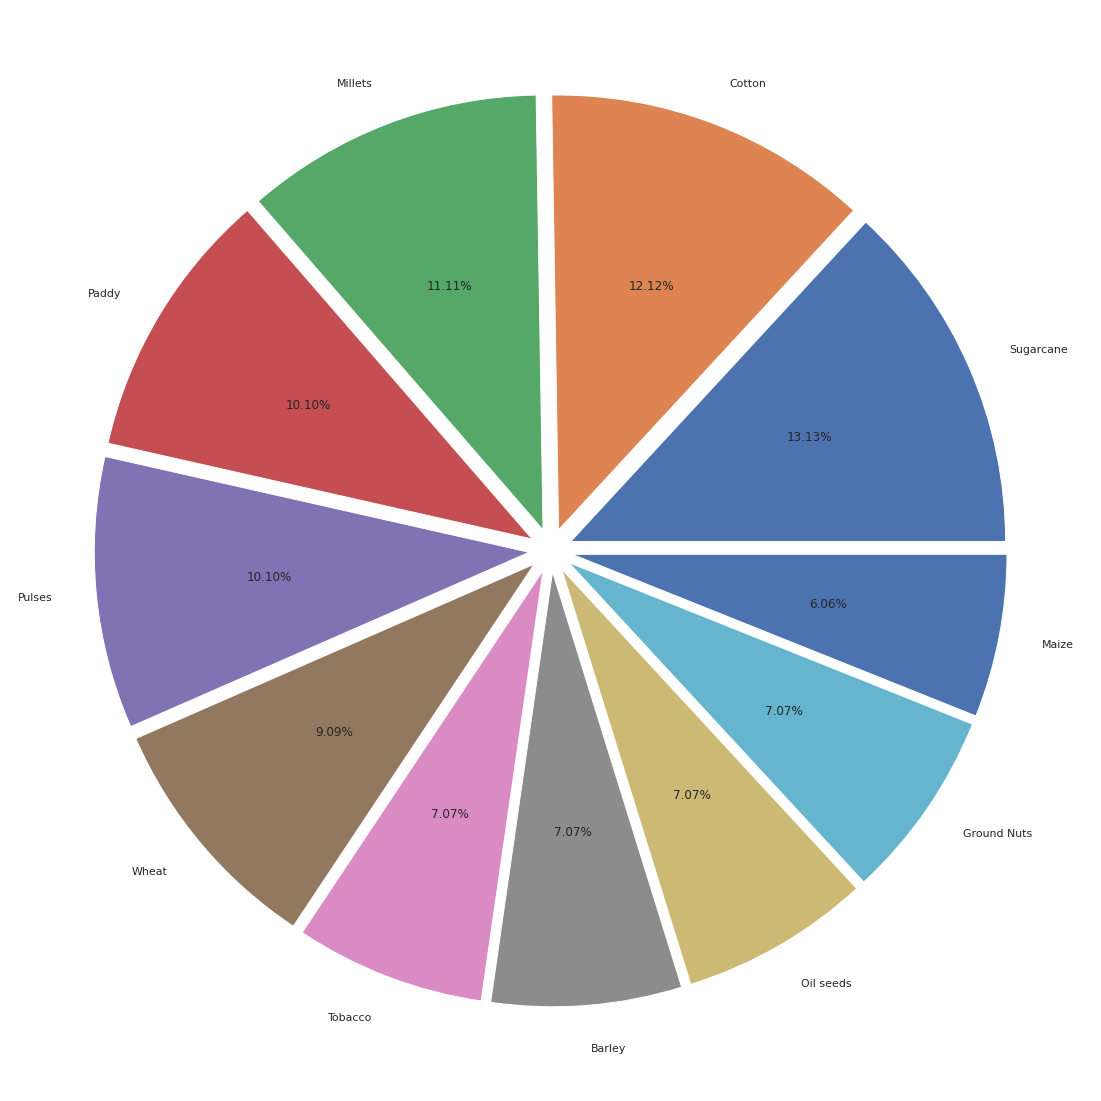

In [13]:
make_pie('Crop Type')

## **Data Engineering**

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Temparature      99 non-null     int64 
 1   Humidity         99 non-null     int64 
 2   Moisture         99 non-null     int64 
 3   Soil Type        99 non-null     object
 4   Crop Type        99 non-null     object
 5   Nitrogen         99 non-null     int64 
 6   Potassium        99 non-null     int64 
 7   Phosphorous      99 non-null     int64 
 8   Fertilizer Name  99 non-null     object
dtypes: int64(6), object(3)
memory usage: 7.1+ KB


In [15]:
def make_label_encoder(original_feature , new_feature) : 
    enc  = LabelEncoder()
    enc.fit(data[original_feature])
    data[new_feature] = enc.transform(data[original_feature])
    data.drop([original_feature],axis=1, inplace=True)
    enc_type = pd.DataFrame(zip(enc.classes_,enc.transform(enc.classes_)),columns=['Original','Encoded'])
    enc_type.set_index('Original')
    print(enc_type)

In [16]:
make_label_encoder('Soil Type','Soil_Code')

  Original  Encoded
0    Black        0
1   Clayey        1
2    Loamy        2
3      Red        3
4    Sandy        4


In [17]:
make_label_encoder('Crop Type','Crop_Code')

       Original  Encoded
0        Barley        0
1        Cotton        1
2   Ground Nuts        2
3         Maize        3
4       Millets        4
5     Oil seeds        5
6         Paddy        6
7        Pulses        7
8     Sugarcane        8
9       Tobacco        9
10        Wheat       10


In [18]:
make_label_encoder('Fertilizer Name','Fertilizer_Code')

   Original  Encoded
0  10-26-26        0
1  14-35-14        1
2  17-17-17        2
3     20-20        3
4     28-28        4
5       DAP        5
6      Urea        6


## **Modelling**

In [19]:
train_main = data.drop('Fertilizer_Code', axis=1).copy()
target = data['Fertilizer_Code'].copy()

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_main, target, train_size=0.7, shuffle=True, random_state=42)

In [21]:
train_col = X_train.columns
test_col = X_test.columns

In [22]:
from sklearn.preprocessing import MinMaxScaler
ms = MinMaxScaler()
X_train = ms.fit_transform(X_train)
X_test = ms.transform(X_test)

In [37]:
pickle_out = open('minmax.pkl','wb')
pickle.dump(ms,pickle_out)
pickle_out.close()

In [23]:
X_train = pd.DataFrame(X_train, columns=[train_col])
X_test = pd.DataFrame(X_test, columns=[test_col])

In [32]:
X_train.head()

Temparature Humidity  Moisture  Nitrogen Potassium Phosphorous Soil_Code  \
0    0.000000  0.000000    0.175  0.527778  0.000000    0.452381      0.25   
1    0.307692  0.363636    0.375  0.527778  0.000000    0.547619      0.75   
2    0.923077  0.909091    0.175  0.194444  0.000000    0.928571      0.00   
3    0.307692  0.363636    0.900  0.166667  0.000000    0.904762      0.50   
4    0.076923  0.090909    0.250  0.194444  0.526316    0.309524      1.00   

  Crop_Code  
0       0.7  
1       0.2  
2       0.5  
3       0.1  
4       0.0

In [24]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators= 100, criterion = 'gini' , random_state= 42)
classifier.fit(X_train, y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


RandomForestClassifier(random_state=42)

In [25]:
y_pred = classifier.predict(X_test)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


In [26]:
from sklearn.metrics import confusion_matrix,classification_report, accuracy_score

accuracy_score(y_test, y_pred)

0.9666666666666667

In [27]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           1       1.00      1.00      1.00         4
           2       1.00      0.50      0.67         2
           3       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         6
           5       1.00      1.00      1.00         7
           6       1.00      1.00      1.00         7

    accuracy                           0.97        30
   macro avg       0.96      0.93      0.93        30
weighted avg       0.97      0.97      0.96        30



In [28]:
from sklearn.tree import DecisionTreeClassifier
model2 = DecisionTreeClassifier()
model2.fit(X_train,y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


DecisionTreeClassifier()

In [29]:
y_pred = model2.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           1       1.00      1.00      1.00         4
           2       1.00      0.50      0.67         2
           3       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         6
           5       1.00      1.00      1.00         7
           6       1.00      1.00      1.00         7

    accuracy                           0.97        30
   macro avg       0.96      0.93      0.93        30
weighted avg       0.97      0.97      0.96        30



/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


In [30]:
import pickle
pickle_out = open('fertilizer.pkl','wb')
pickle.dump(model2,pickle_out)
pickle_out.close()